In [2]:
import numpy as np
import matplotlib.pyplot as plt
from agent.agent import DQNAgent, GradientAgent, LawnMowingAgent, RandomAgent
from environments.custom_diffusion_field import CustomDifusionFieldEnvironment

## Trajectory Planning

In [3]:
# setup_environment: generate field environment & source Detector
def setup_environment(start_position, params):
    env = CustomDifusionFieldEnvironment("single-field-no-loc-9-actions", params=params)
    env.reset(start_pos=start_position)
    state, _, _ = env.step(4) # temp: need to take a "stay" step to avoid bug in destination chooser
    return env, state

# compose_input_params: extract additional data from environment to pass to agent (all all agents need this)
def compose_input_params(env):
    return {'position': env.agent_position, 'action_probs': env.get_next_action_probs(env.agent_position), \
                   'field_visited': env.agent_field_visited, 'field_size': env.field_size, 'n_srcs': env.num_sources} 

## Plot Environments

In [4]:
# plot env_field and mapping_error from all envs
def plot_environment_state(env, name, save=True):    
    import matplotlib.patches as patches

    fig_learning, fig_learning_axes = plt.subplots(1, 2, figsize=(20, 10))

    fig_learning_axes[0].set_title(f"Environment Field End State [{name}]")
    fig_learning_axes[0].set_aspect("equal")
    fig_learning_axes[1].set_title("Mapping Error")
    fig_learning_axes[1].set_xlim([0, env.max_num_steps])

    # Plot 1: Environment End state
    fig_learning_axes[0].imshow(env.env_curr_field, cmap="Blues")

    traj_r = [position[1] for position in env.agent_trajectory]
    traj_c = [position[0] for position in env.agent_trajectory]
    fig_learning_axes[0].plot(traj_r, traj_c, '.', color='black')

    # print(self.agent_trajectory)
    fig_learning_axes[0].plot(
        env.agent_trajectory[0][0], env.agent_trajectory[0][1], '*', color='red')

    view_scope_box = patches.Rectangle(
        (env.agent_trajectory[-1][1] - env.view_scope_half_side,
         env.agent_trajectory[-1][0] - env.view_scope_half_side), env.view_scope_half_side*2+1, env.view_scope_half_side*2+1,
        linewidth=2, edgecolor='r', facecolor='none')
    fig_learning_axes[0].add_patch(view_scope_box)

    # Plot 2: Mapping Error
    fig_learning_axes[1].plot(env.mapping_errors, '.-')
    if save:
        plt.savefig(f'outputs/experiment_trajectory_{name}.png', facecolor='white', transparent=False)
    plt.show()

In [5]:
# plot env_field and mapping_error from all envs
def plot_all_mapping_errors(envs=[], names=[], save=True):    
    import matplotlib.patches as patches

    fig_learning, fig_learning_axes = plt.subplots(1, 2, figsize=(20, 10))
    
    fig_learning_axes[0].set_title(f"Environment Field End State")
    fig_learning_axes[0].set_aspect("equal")        
    fig_learning_axes[0].imshow(envs[0].env_curr_field, cmap="Blues")
    fig_learning_axes[1].set_title("Mapping Error")
    fig_learning_axes[1].set_xlim([0, envs[0].max_num_steps])
    
    colors = ['red', 'blue', 'green', 'black']
    names = ['DQN', 'Gradient', 'LawnMowing', 'Random']

    
    for i in range(len(envs)):        
        traj_r = [position[1] for position in envs[i].agent_trajectory]
        traj_c = [position[0] for position in envs[i].agent_trajectory]
        fig_learning_axes[0].plot(traj_r, traj_c, '.', color=colors[i], label=names[i])     
        fig_learning_axes[0].plot(envs[i].agent_trajectory[0][0], envs[i].agent_trajectory[0][1], '*', color=colors[i])
        fig_learning_axes[0].legend()

        view_scope_box = patches.Rectangle(
            (envs[i].agent_trajectory[-1][1] - envs[i].view_scope_half_side,
             envs[i].agent_trajectory[-1][0] - envs[i].view_scope_half_side), envs[i].view_scope_half_side*2+1, envs[i].view_scope_half_side*2+1,
            linewidth=2, edgecolor=colors[i], facecolor='none')
        fig_learning_axes[0].add_patch(view_scope_box)

        # Plot 2: Mapping Error
        fig_learning_axes[1].plot(envs[i].mapping_errors, '.-', label=names[i])
        fig_learning_axes[1].legend()
    if save:
        plt.savefig(f'outputs/experiment_mapping_all.png', facecolor='white', transparent=False)
    plt.show()

## Experiment with 2 Sources

### Test DQN Agent

/home/thinh/miniconda3/envs/dl/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


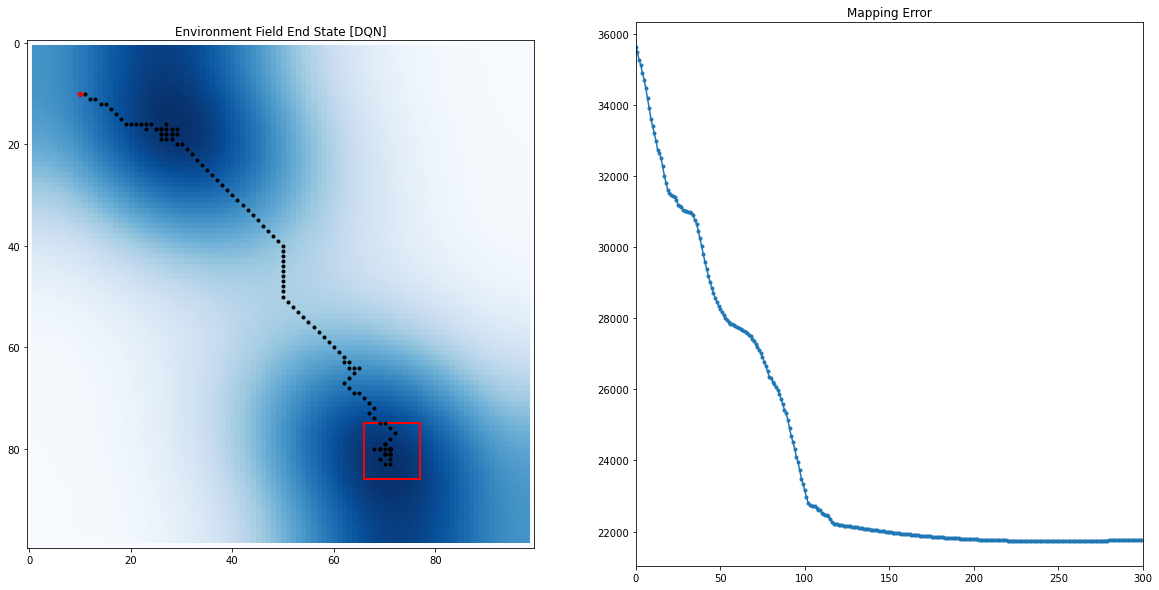

In [6]:
START_POS = [10, 10]
MAX_STEPS = 300
FIELD_PARAMS = {"vx": 0.0, "vy": 0.0, "k": 1.5, "dx": 0.8, "dy": 0.8, "n_source": 2, \
                "max_steps": MAX_STEPS, "half_scope_size": 5, "field_path": "./environments/field_2src.npy"}

agent = DQNAgent()
env, state = setup_environment(START_POS, FIELD_PARAMS)
source_found = False
done = False

# run all agents in their separate environments for MAX_STEPS
for step in range(MAX_STEPS):
    if done:
        continue
    input_params = compose_input_params(env)
    action = agent.get_next_action(state, input_params)
    state, done, observation = env.step(action)

plot_environment_state(env, 'DQN')        

### Test All Agents

In [6]:
START_POS = [10, 10]
NUM_ENV = 4
MAX_STEPS = 400
FIELD_PARAMS = {"vx": 0.0, "vy": 0.0, "k": 1.5, "dx": 0.8, "dy": 0.8, "n_source": 2, \
                "max_steps": MAX_STEPS, "half_scope_size": 5, "field_path": "./environments/field_2src.npy"}


agents = [DQNAgent(), GradientAgent(), LawnMowingAgent(), RandomAgent()]
env_names = ['DQN', 'Gradient', 'LawnMowing', 'Random']
envs, states = map(list,zip(*[setup_environment(START_POS, FIELD_PARAMS) for i in range(NUM_ENV)]))
dones = [False for i in range(NUM_ENV)]

# run all agents in their separate environments for MAX_STEPS
for step in range(MAX_STEPS):
    for i in range(NUM_ENV):
        if dones[i]:
            continue
        input_params = compose_input_params(envs[i])
        action = agents[i].get_next_action(states[i], input_params) # if not source_founds[i] else 4 # stay
        state, done, observation = envs[i].step(action)
        states[i] = state
        dones[i] = done


/home/thinh/miniconda3/envs/dl/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


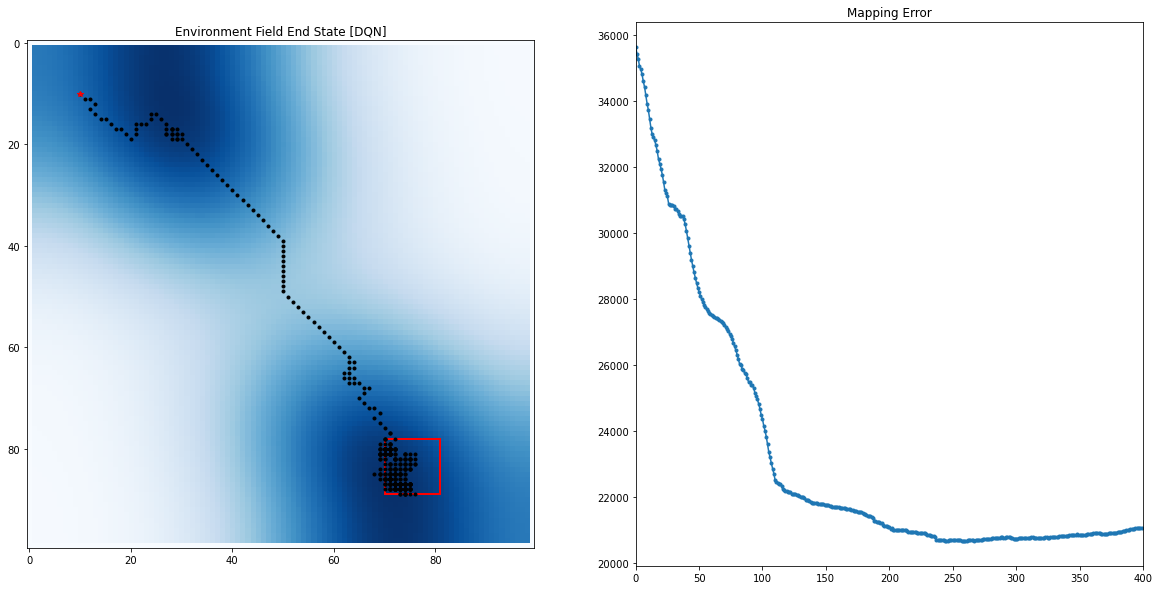

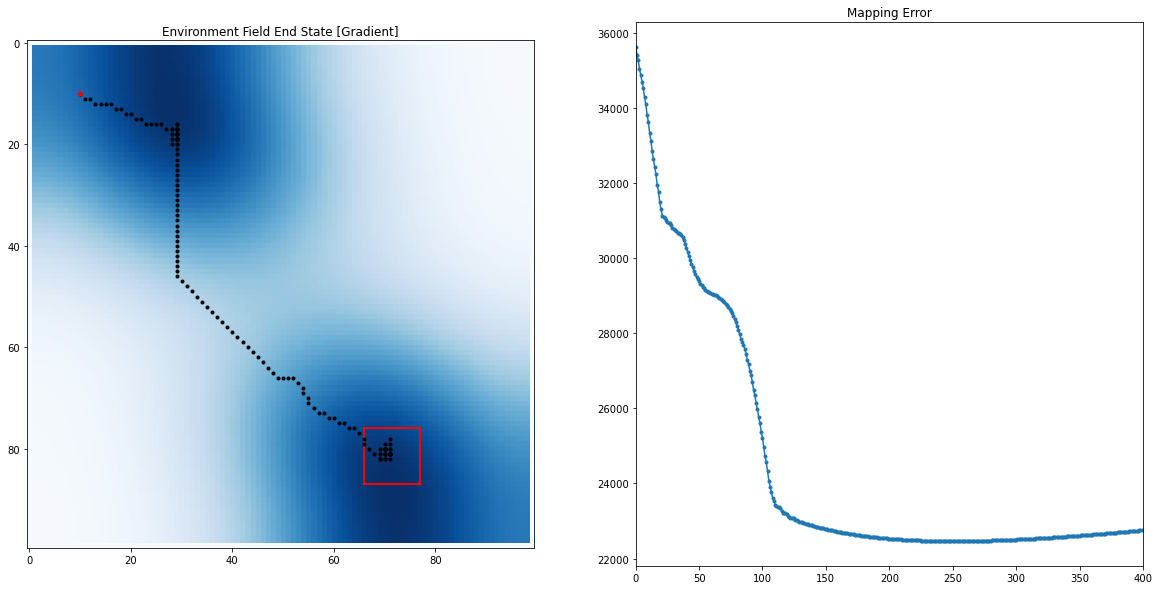

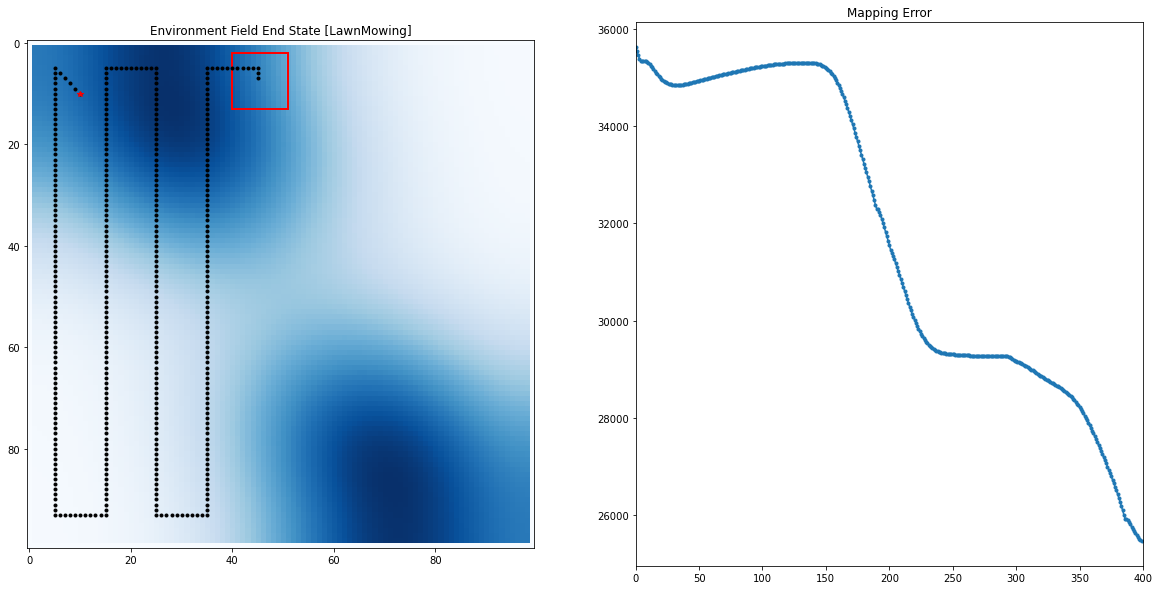

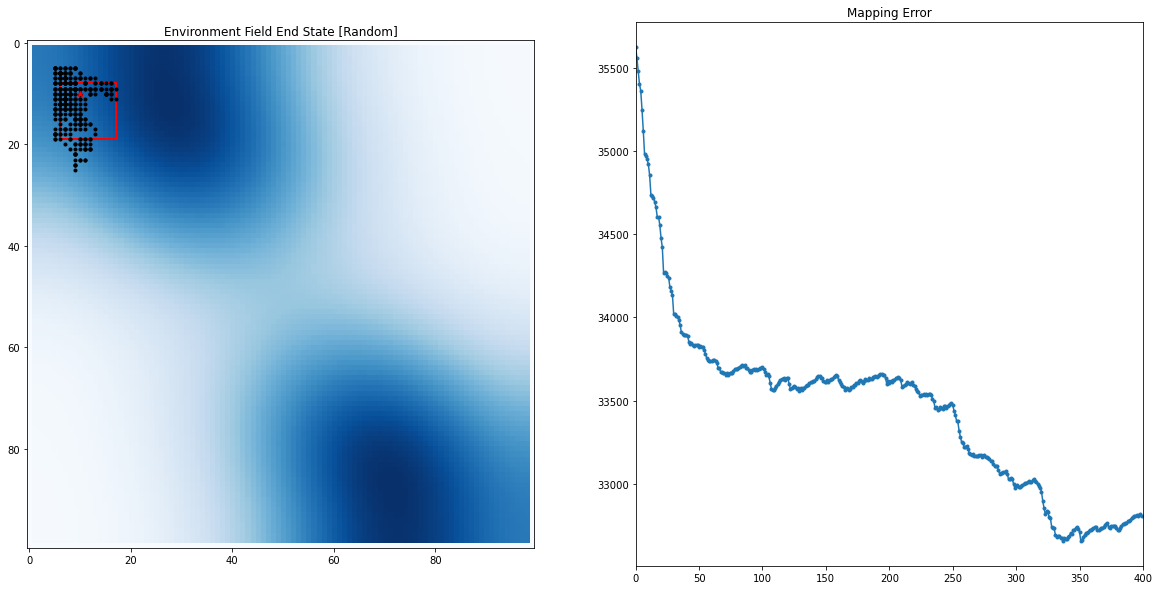

In [7]:
# Plot all fields
for i in range(len(envs)):
    plot_environment_state(env=envs[i], name=env_names[i])

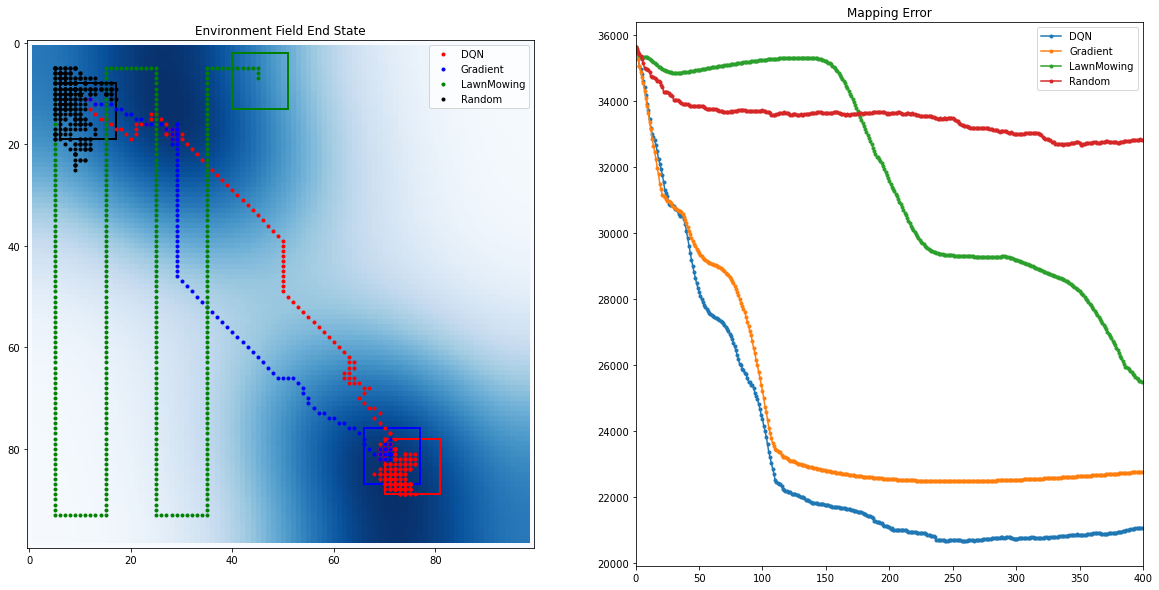

In [8]:
# Plot mapping errrors together
plot_all_mapping_errors(envs=envs, names=env_names)